In [1]:
#Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 
import dask.dataframe as dd
import multiprocessing
import numpy as np

In [2]:
T_News = pd.read_csv('True.csv')
T_News.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [3]:
F_News = pd.read_csv('Fake.csv')
F_News.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
print(F_News.shape)
print(T_News.shape)

(23481, 4)
(21417, 4)


In [5]:
def text_extractor(row):
    row['agency'] = row.text.split('-')[0]
    row.text = ' '.join(row.text.split('-')[1:])
    return(row)

In [6]:
T_News = T_News.apply(text_extractor,axis=1)

In [7]:
F_News['Fake']=1
T_News['Fake']=0
News = pd.concat([T_News,F_News],ignore_index=True)
News.head()

,title,text,subject,date,agency,Fake
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",WASHINGTON (Reuters),0
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",WASHINGTON (Reuters),0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",WASHINGTON (Reuters),0
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",WASHINGTON (Reuters),0
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters),0


In [8]:
#importing libraries for cleaning text
import nltk
import re

#Creating a function to clean text and git rid of punctuations, stopwords, and lowering the text
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
from nltk.stem import PorterStemmer
ps = PorterStemmer()

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords and non english words out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    stem_tokens = [ps.stem(word) for word in filtered_tokens]
    doc = ' '.join(stem_tokens)
    return doc

# defining a function to clean the text in our dataframe.
def dataframe_normalize(row):
    row.text = normalize_document(row.text)
    return(row)


In [9]:
#Using dask for faster process
News_clean = dd.from_pandas(News, npartitions=4*multiprocessing.cpu_count())\
    .map_partitions(lambda df: df.apply(dataframe_normalize,axis =1))\
    .compute(scheduler='processes')

In [10]:
maxlen = max(News_clean['text'].str.split().apply(len))
print(maxlen)
max_words = 20000
embedding_dim = 100

8502


In [11]:
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras import layers
#from keras.models import Sequential
#import keras.models as models

Using TensorFlow backend.


In [12]:
tokenizer = Tokenizer(num_words = max_words )
tokenizer.fit_on_texts(News_clean.text.values)
sequences = tokenizer.texts_to_sequences(News_clean.text.values)
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(News_clean.Fake.values)

#x_train, x_test, y_train, y_test = train_test_split(data, labels, random_state=42, test_size=0.3)

In [14]:
data

array([[   0,    0,    0, ...,  352,   38,  351],
       [   0,    0,    0, ..., 2242, 1671, 1494],
       [   0,    0,    0, ...,    3,  849,    1],
       ...,
       [   0,    0,    0, ...,  627,  260,  489],
       [   0,    0,    0, ...,  627, 4654,  283],
       [   0,    0,    0, ...,  627,  219,  489]])

In [13]:
model =Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.LSTM(32))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [14]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['acc'])

history = model.fit(x_train, y_train, epochs = 2, validation_split = 0.2)

c:\users\a_raf\anaconda3\envs\keras-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25142 samples, validate on 6286 samples
Epoch 1/2
25142/25142 [==============================] - 7284s 290ms/step - loss: 0.1346 - acc: 0.9593 - val_loss: 0.0631 - val_acc: 0.9812
Epoch 2/2
25142/25142 [==============================] - 7093s 282ms/step - loss: 0.0475 - acc: 0.9868 - val_loss: 0.0365 - val_acc: 0.9890


In [15]:
# serialize weights to HDF5
model.save_weights("model_text.h5")
print("Saved model weights to disk")

Saved model weights to disk


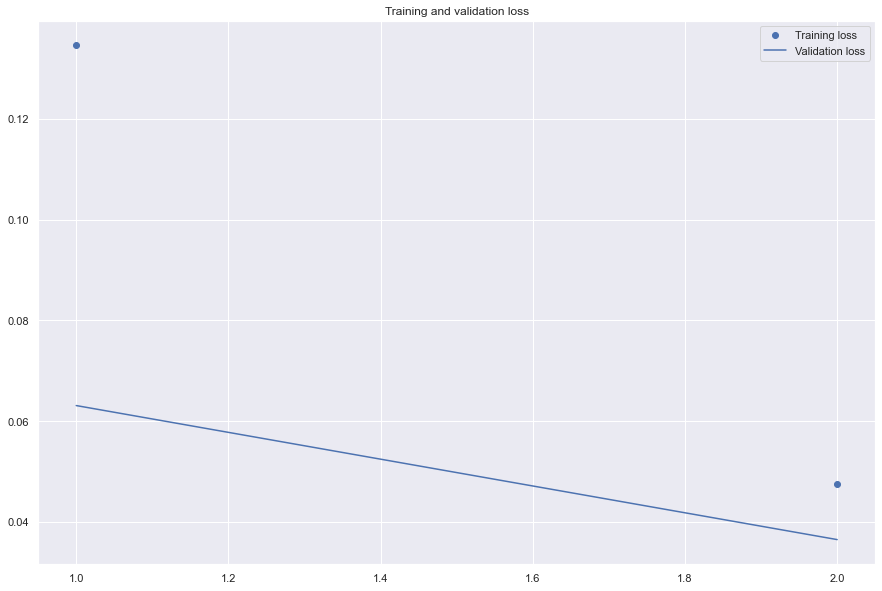

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

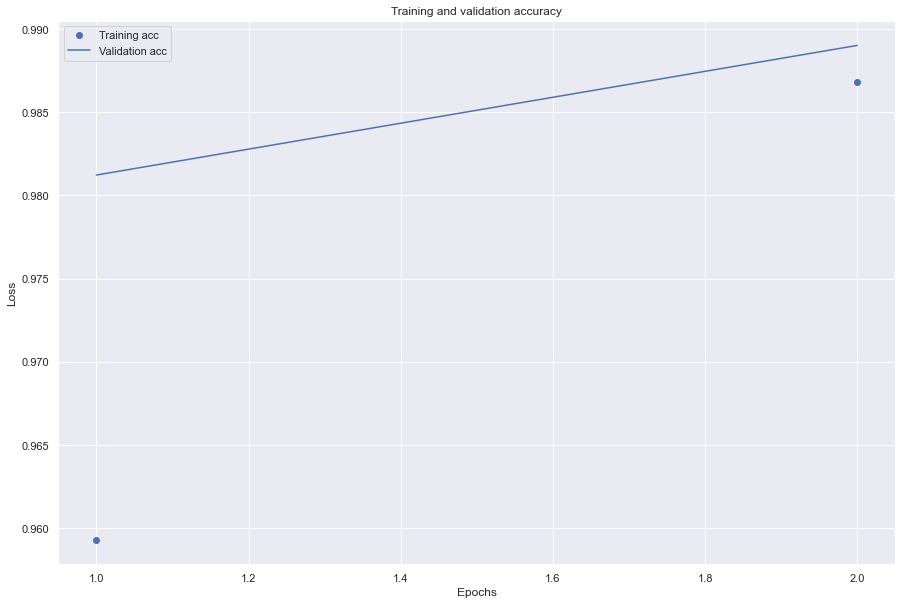

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.figure(figsize=(15,10))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_test_pred = model.predict(x_test)

print(confusion_matrix(y_test, np.round(y_test_pred)))
print(classification_report(y_test, np.round(y_test_pred)))

[[6389   85]
 [  77 6919]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6474
           1       0.99      0.99      0.99      6996

    accuracy                           0.99     13470
   macro avg       0.99      0.99      0.99     13470
weighted avg       0.99      0.99      0.99     13470



### News title Analysis

In [19]:
# defining a function to clean the title in our dataframe.
def dataframe_normalize(row):
    row.title = normalize_document(row.title)
    return(row)


In [20]:
News_title_clean = dd.from_pandas(News, npartitions=4*multiprocessing.cpu_count())\
    .map_partitions(lambda df: df.apply(dataframe_normalize,axis =1))\
    .compute(scheduler='processes')

In [21]:
maxlen = max(News_title_clean['title'].str.split().apply(len))
print(maxlen)

29


In [22]:
tokenizer2 = Tokenizer(num_words = max_words )
tokenizer2.fit_on_texts(News_title_clean.title.values)
sequences2 = tokenizer2.texts_to_sequences(News_title_clean.title.values)
data = pad_sequences(sequences2, maxlen=maxlen)
labels = np.asarray(News_title_clean.Fake.values)

x_train2, x_test2, y_train2, y_test2 = train_test_split(data, labels, random_state=42, test_size=0.3)

In [23]:
model2 =Sequential()
model2.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model2.add(layers.LSTM(32))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(1, activation='sigmoid'))

In [24]:
model2.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['acc'])

history = model2.fit(x_train2, y_train2, epochs = 10, validation_split = 0.2)

c:\users\a_raf\anaconda3\envs\keras-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25142 samples, validate on 6286 samples
Epoch 1/10
25142/25142 [==============================] - 25s 1ms/step - loss: 0.2187 - acc: 0.9140 - val_loss: 0.1464 - val_acc: 0.9394
Epoch 2/10
25142/25142 [==============================] - 25s 1ms/step - loss: 0.1199 - acc: 0.9556 - val_loss: 0.1288 - val_acc: 0.9483
Epoch 3/10
25142/25142 [==============================] - 25s 1ms/step - loss: 0.1010 - acc: 0.9639 - val_loss: 0.1311 - val_acc: 0.9508
Epoch 4/10
25142/25142 [==============================] - 25s 1ms/step - loss: 0.0886 - acc: 0.9690 - val_loss: 0.1445 - val_acc: 0.9467
Epoch 5/10
25142/25142 [==============================] - 25s 1ms/step - loss: 0.0813 - acc: 0.9712 - val_loss: 0.1289 - val_acc: 0.9513
Epoch 6/10
25142/25142 [==============================] - 25s 1ms/step - loss: 0.0717 - acc: 0.9751 - val_loss: 0.1275 - val_acc: 0.9518
Epoch 7/10
25142/25142 [==============================] - 25s 1ms/step - loss: 0.0641 - acc: 0.9780 - val_loss: 0.1288 - val_acc:

In [25]:
model2.save('title_model')

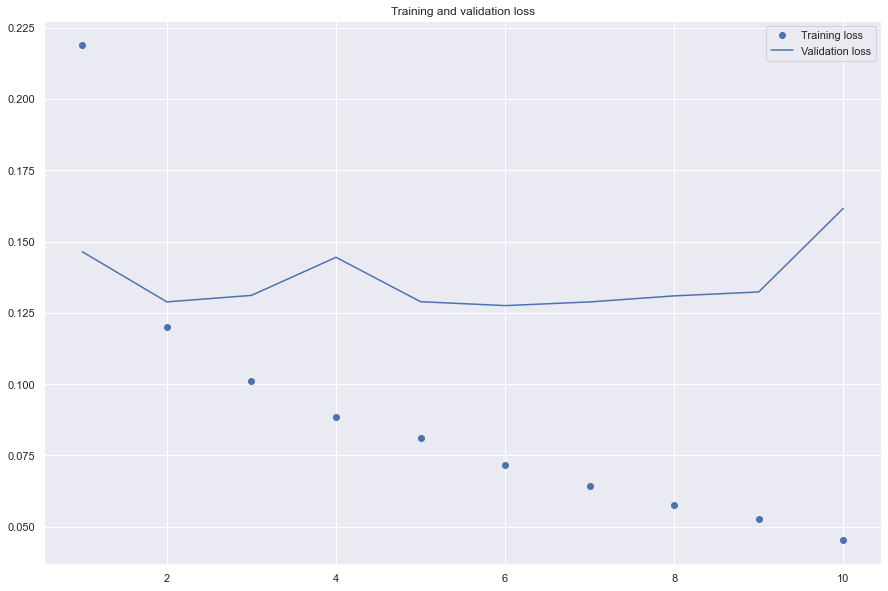

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

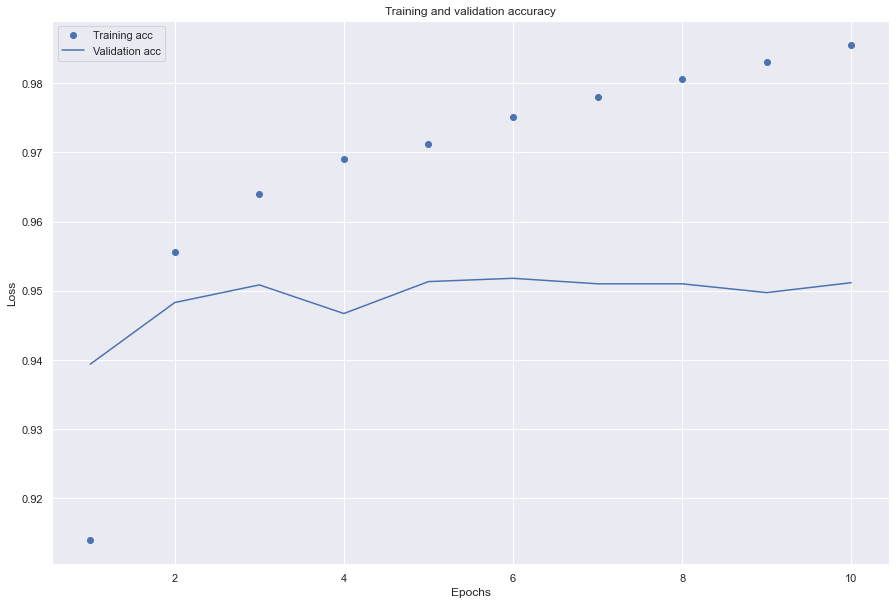

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.figure(figsize=(15,10))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
y_test_pred2 = model2.predict(x_test2)

print(confusion_matrix(y_test2, np.round(y_test_pred2)))
print(classification_report(y_test2, np.round(y_test_pred2)))

[[6189  285]
 [ 335 6661]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      6474
           1       0.96      0.95      0.96      6996

    accuracy                           0.95     13470
   macro avg       0.95      0.95      0.95     13470
weighted avg       0.95      0.95      0.95     13470



### Combining title and text analysis

In [29]:
print(confusion_matrix(y_test, np.round((y_test_pred+y_test_pred2)/2)))
print(classification_report(y_test, np.round((y_test_pred+y_test_pred2)/2)))

[[6403   71]
 [  32 6964]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      6474
           1       0.99      1.00      0.99      6996

    accuracy                           0.99     13470
   macro avg       0.99      0.99      0.99     13470
weighted avg       0.99      0.99      0.99     13470



In [30]:
prediction = [x[0] for x in np.round((y_test_pred+y_test_pred2)/2).astype(int)]
data = np.arange(44898)
x_train_idx, x_test_idx, y_train_idx, y_test_idx = train_test_split(data, labels, random_state=42, test_size=0.3)
test_News = News.iloc[list(x_test_idx)]
test_News['prediction'] = prediction
test_News.reset_index(inplace =True, drop = True)
test_News.head()

c:\users\a_raf\anaconda3\envs\keras-gpu\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,title,text,subject,date,agency,Fake,prediction
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",NaN,1,1
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",NaN,1,1
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",NaN,1,1
3,California AG pledges to defend birth control ...,California Attorney General Xavier Becerra sa...,politicsNews,"October 6, 2017",SAN FRANCISCO (Reuters),0,0
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",NaN,1,1


In [31]:
#Looking at a sample of Fake news detected as true.
test_News[(test_News.Fake == 1) & (test_News.prediction == 0)].title.iloc[0]

'“OUR MORAL OBLIGATION” – Obama Visits Laos And Vietnam On Apology Tour…Pledges Millions'

In [32]:
test_News[(test_News.Fake == 1) & (test_News.prediction == 0)].text.iloc[0]

'President Barack Obama pledged $90 million ( 67 million) on Tuesday to help Laos recover millions of unexploded bombs secretly dropped there by US planes during the Vietnam War, saying the clean-up was a  moral obligation . Mr Obama is in Laos for a summit of Southeast Asian leaders, making him the first sitting president to visit the communist country, which is sandwiched between Thailand and Vietnam.A young boy stands in front of a building made with repurposed bomb shells.He said it was time to at last acknowledge the toll American bombing had taken on the people of Laos. Villages and entire valleys were obliterated. Countless civilians were killed. That conflict was another reminder that, whatever the cause, whatever our intentions, war inflicts a wrenching toll, especially on innocent men, women and children,  he said.Read more: Telegraph '

In [33]:
id = test_News[(test_News.Fake == 1) & (test_News.prediction == 0)].index[0]
print('title prediction :', y_test_pred2[id][0] )
print('text prediction :', y_test_pred[id][0])

title prediction : 0.043439474
text prediction : 0.63573


In [34]:
#Looking at a sample of True news detected as fake
test_News[(test_News.Fake == 0) & (test_News.prediction == 1)].title.iloc[0]

'Factbox: Trump on Twitter (Sept 25) - NASCAR, NFL, John Kelly, Puerto Rico, John McCain, Alabama'

In [35]:
test_News[(test_News.Fake == 0) & (test_News.prediction == 1)].text.iloc[0]

' So proud of NASCAR and its supporters and fans. They won’t put up with disrespecting our Country or our Flag   they said it loud and clear! [0725 EDT]   Many people booed the players who kneeled yesterday (which was a small percentage of total). These are fans who demand respect for our Flag! [0731 EDT]   The issue of kneeling has nothing to do with race. It is about respect for our Country, Flag and National Anthem. NFL must respect this! [0739 EDT]   The White House never looked more beautiful than it did returning last night. Important meetings taking place today. Big tax cuts & reform. [0744 EDT]   #StandForOurAnthem [0902 EDT]   @CNN is #FakeNews. Just reported COS (John Kelly) was opposed to my stance on NFL players disrespecting FLAG, ANTHEM, COUNTRY. Total lie! [1826 EDT]   General John Kelly totally agrees w/ my stance on NFL players and the fact that they should not be disrespecting our FLAG or GREAT COUNTRY! [1828 EDT]   Tremendous backlash against the NFL and its players 

In [36]:
id = test_News[(test_News.Fake == 0) & (test_News.prediction == 1)].index[1]
print('title prediction :', y_test_pred2[id][0] )
print('text prediction :', y_test_pred[id][0])

title prediction : 0.7932334
text prediction : 0.9776228
